In [ ]:
import scanpy as sc
from os.path import join
# data_dir = 'E:/yan0/Papers/SpaMosaic-main/SpaMosaic-main/data/E13'
# adata_omics1 = sc.read_h5ad(join(data_dir, 'E13_adata_rna.h5ad'))
# adata_omics2 = sc.read_h5ad(join(data_dir, 'E13_adata_atac.h5ad'))

data_dir = 'E:/yan0/Papers/SpaMosaic-main/SpaMosaic-main/data/mouse_embryo_rna_atac_slice1'
adata_omics1 = sc.read_h5ad(join(data_dir, 's1_adata_rna.h5ad'))
adata_omics2 = sc.read_h5ad(join(data_dir, 's1_adata_atac.h5ad'))

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

In [ ]:
adata_omics1

In [ ]:
adata_omics2

In [ ]:
import pandas as pd
meta=pd.read_csv(data_dir + '/meta.tsv', sep='\t')

In [ ]:
adata_omics1.obs

In [ ]:
# 去除 obs 中 barcode 前缀 "mult-"，确保两者格式匹配
adata_omics1.obs.index = adata_omics1.obs.index.str.replace("mult-", "", regex=False)

In [ ]:
extra_barcodes = set(meta['barcode']) - set(adata_omics1.obs.index)

In [ ]:
extra_barcodes

In [ ]:
meta = meta[~meta["barcode"].isin(extra_barcodes)]

In [ ]:
adata_omics1.obs = meta

In [ ]:
adata_omics1.obs

In [ ]:
adata_omics2.obs = meta

In [ ]:
adata_omics2

In [ ]:
sc.pl.embedding(adata_omics1, basis='spatial', color=['RNA_clusters'], title=['RNA(GT)'], s=100, show=False)

In [ ]:
sc.pl.embedding(adata_omics2, basis='spatial', color=['ATAC_clusters'], title=['ATAC(GT)'], s=100, show=False)

In [ ]:
sc.pl.embedding(adata_omics1, basis='spatial', color=['Joint_clusters'], title=['joint(GT)'], s=100, show=False)

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# # 假设 adata_omics1 已经加载并正确处理
# sc.pl.embedding(
#     adata_omics1,
#     basis='spatial',
#     color=['Joint_clusters'],
#     s=100,
#     show=False
# )

# 创建新的图像，并设置大小
fig, ax = plt.subplots(figsize=(3,3))  # 设置图像宽度为 10 英寸，高度为 8 英寸

# 绘制图像，将图绘制到自定义的 `ax` 上
sc.pl.embedding(
    adata_omics1, 
    basis='spatial', 
    color='Joint_clusters', 
    # title=f'Ours--ARI:{ari_score_ours:.4f}', 
    s=60, 
    show=False, 
    ax=ax,  # 将绘制放入指定的 `ax`
    # legend_loc=None  # 禁用图例

)

# 获取当前轴并移除坐标
plt.gca().axis('off')

# 隐藏标题
plt.title('')
save_path = "E:/yan0/ours/result/figs/integration/mouse_embryo/gt.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
# 显示图像
plt.show()


In [ ]:
def run_leiden(adata1, n_cluster, use_rep="embeddings", key_added="Nleiden", range_min=0, range_max=3, max_steps=30, tolerance=0):
    adata = adata1.copy()
    sc.pp.neighbors(adata, use_rep=use_rep)
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(adata, resolution=this_resolution)
        this_clusters = adata.obs['leiden'].nunique()

        if this_clusters > n_cluster+tolerance:
            this_max = this_resolution
        elif this_clusters < n_cluster-tolerance:
            this_min = this_resolution
        else:
            print("Succeed to find %d clusters at resolution %.3f"%(n_cluster, this_resolution))
            adata1.obs[key_added] = adata.obs["leiden"]
            
            return adata1
        
        this_step += 1
    
    print('Cannot find the number of clusters')
    adata1.obs[key_added] = adata.obs["leiden"]
    return adata1

In [ ]:
sc.pp.neighbors(adata_omics1)
sc.tl.leiden(adata_omics1, key_added='leiden1', random_state=10, resolution=0.6)
sc.pl.embedding(adata_omics1, basis='spatial',color='leiden1',title=f'RNA',s=100, show=False)

In [ ]:
adata_omics1 = run_leiden(adata_omics1, n_cluster=14, use_rep="X", key_added="leiden")

In [ ]:
adata_omics1.obs['leiden']

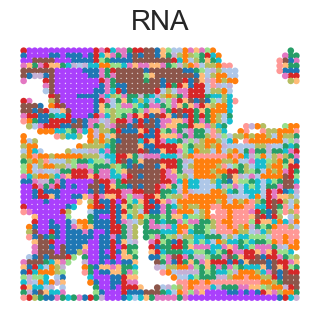

In [27]:
# visualization
import matplotlib.pyplot as plt

# 创建新的图像，并设置大小
fig, ax = plt.subplots(figsize=(3,3))  # 设置图像宽度为 10 英寸，高度为 8 英寸

# 绘制图像，将图绘制到自定义的 `ax` 上
sc.pl.embedding(
    adata_omics1, 
    basis='spatial', 
    color='leiden1', 
    title=f'RNA', 
    s=90, 
    show=False, 
    ax=ax,  # 将绘制放入指定的 `ax`
    legend_loc=None  # 禁用图例
)

# 设置标题字体大小
ax.set_title(f'RNA', fontsize=20)

# 去除坐标轴
ax.axis('off')

# 调整布局，减少多余空白
plt.tight_layout(pad=0)

# 保存图像到指定路径
save_path = "E:/yan0/ours/result/figs/integration/mouse_embryo/RNA.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

# 显示图像
plt.show()

<Axes: title={'center': 'ATAC'}, xlabel='spatial1', ylabel='spatial2'>

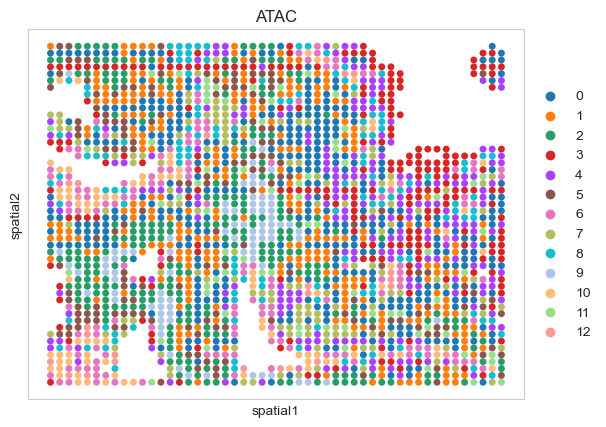

In [58]:
sc.pp.neighbors(adata_omics2,use_rep='X')
sc.tl.leiden(adata_omics2, key_added='leiden1', random_state=10, resolution=2)
sc.pl.embedding(adata_omics2, basis='spatial',color='leiden1',title=f'ATAC',s=100, show=False)

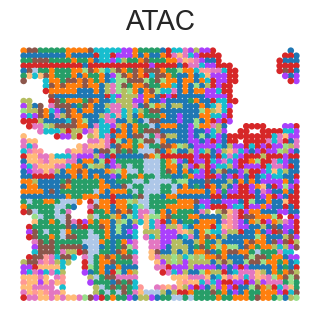

In [59]:
# visualization
import matplotlib.pyplot as plt

# 创建新的图像，并设置大小
fig, ax = plt.subplots(figsize=(3,3))  # 设置图像宽度为 10 英寸，高度为 8 英寸

# 绘制图像，将图绘制到自定义的 `ax` 上
sc.pl.embedding(
    adata_omics2, 
    basis='spatial', 
    color='leiden1', 
    title=f'RNA', 
    s=90, 
    show=False, 
    ax=ax,  # 将绘制放入指定的 `ax`
    legend_loc=None  # 禁用图例
)

# 设置标题字体大小
ax.set_title(f'ATAC', fontsize=20)

# 去除坐标轴
ax.axis('off')

# 调整布局，减少多余空白
plt.tight_layout(pad=0)

# 保存图像到指定路径
save_path = "E:/yan0/ours/result/figs/integration/mouse_embryo/ATAC.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

# 显示图像
plt.show()

In [35]:
from codes.DiTs import *
from codes.train_diff import *
from codes.ZINB_encoder import *
from codes.sampler import *

E:\yan0\ours\run_diff_ours_code
NVIDIA GeForce RTX 4060


In [36]:
from SpatialGlue.preprocess import lsi,pca

# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

# ATAC
# adata_omics2 = adata_omics2[adata_omics1.obs_names].copy()  # .obsm['X_lsi'] represents the dimension reduced feature

In [37]:
if 'X_lsi' not in adata_omics2.obsm.keys():
    sc.pp.highly_variable_genes(adata_omics2, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata_omics2, use_highly_variable=False, n_components=51)

adata_omics2.obsm['feat'] = adata_omics2.obsm['X_lsi'].copy()

In [38]:
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]

In [39]:
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.obsm['X_lsi'].shape[1])

In [40]:
# from get_graph import construct_neighbor_graph,adjacent_matrix_preprocessing
# from get_graph import construct_neighbor_graph
from SpatialGlue.preprocess import adjacent_matrix_preprocessing,construct_neighbor_graph

# Specify data type
data_type = '10x'

adata = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type)

In [41]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

adj = adjacent_matrix_preprocessing(adata_omics1, adata_omics2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)
# adj['adj_feature_omics2'] = adj['adj_feature_omics2'].to(device)

In [42]:
from codes.get_graph import construct_neighbor_graph, adjacent_matrix_preprocessing

# Specify data type
data_type = '10x'

adata_omics1, adata_omics2 = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type,n_neighbors=3) # 空间不要用10个邻居，就3个ZINB编码更好

In [43]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

adj = adjacent_matrix_preprocessing(adata_omics1, adata_omics2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)

In [51]:
ae_model = DenoiseST(
    adata=adata_omics1,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    epochs=300,
    dim_output=128
)

adata_omics1.obsm['emb1'], adj_mat = ae_model.train()

 19%|█▉        | 58/300 [00:01<00:04, 53.79it/s]

Early stop!
Optimization finished for ST data!


In [55]:
adata_omics1 = run_leiden(adata_omics1, n_cluster=14, use_rep="emb1", key_added="AE_ZINB")

Succeed to find 14 clusters at resolution 0.844


In [53]:
from SpatialGlue.utils import clustering

tool = 'mclust'  # mclust, leiden, and louvain
# clustering(adata_omics1, key='emb_latent_omics1', add_key='AE', n_clusters=10, end=1.5, method=tool, use_pca=True)
clustering(adata_omics1, key='emb1', add_key='AE_ZINB', n_clusters=14, end=1.8, method=tool, use_pca=True)
# clustering(adata_omics1, key='denoise_emb', add_key='Denoise', n_clusters=10, end=1.4, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


In [ ]:
sc.pp.neighbors(adata_omics1)
sc.tl.leiden(adata_omics1, key_added='leiden1', random_state=10, resolution=1.555)

In [56]:
from sklearn.metrics import adjusted_rand_score

ground_truth = adata_omics1.obs['Joint_clusters']
# leiden1 = adata_omics1.obs['leiden1']
# ae = adata_omics1.obs['AE']
ae_zinb = adata_omics1.obs['AE_ZINB']
# denoise = adata_omics1.obs['Denoise']

# ari_score_lei = adjusted_rand_score(ground_truth, leiden1)
# ari_score_ae = adjusted_rand_score(ground_truth, ae)
ari_score_aezinb = adjusted_rand_score(ground_truth, ae_zinb)
# ari_score_denoise = adjusted_rand_score(ground_truth, denoise)
ari_score_aezinb

0.3484021315440388

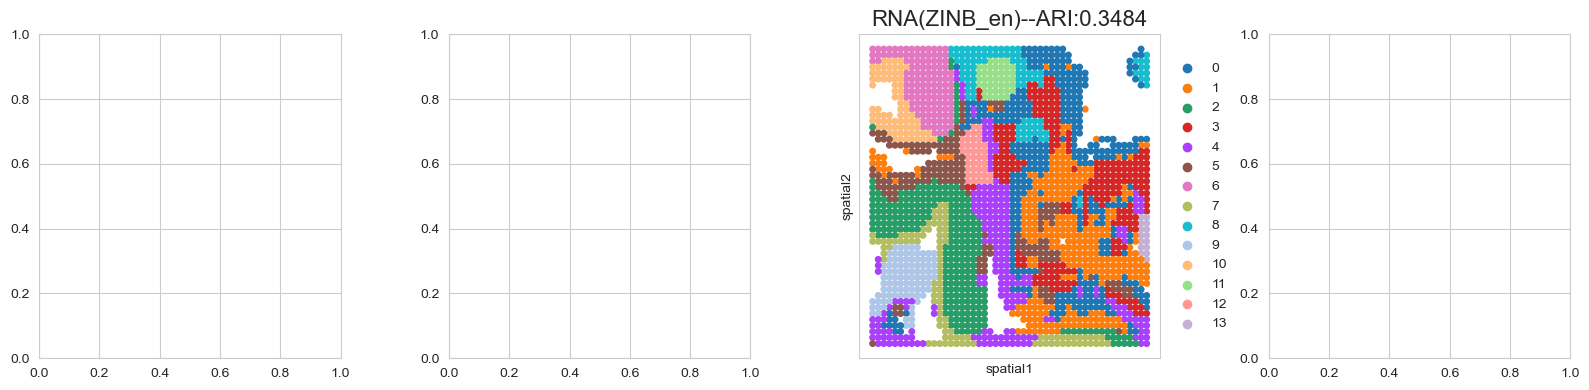

In [57]:
## 蛋白质做条件
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 4, figsize=(16, 4))

# sc.pl.embedding(adata_omics1, basis='spatial', color='leiden1', ax=ax_list[0], s=100, show=False)
# 
# sc.pl.embedding(adata_omics1, basis='spatial',color='AE', ax=ax_list[1],s=100, show=False)
# ax_list[1].set_title(f'RNA(GCN)--ARI:{ari_score_ae:.4f}', fontsize=16)
# 
sc.pl.embedding(adata_omics1, basis='spatial', color='AE_ZINB', ax=ax_list[2], s=100, show=False)
ax_list[2].set_title(f'RNA(ZINB_en)--ARI:{ari_score_aezinb:.4f}', fontsize=16)

# sc.pl.embedding(adata_omics1, basis='spatial',color='Denoise', ax=ax_list[3],s=50, show=False)
# ax_list[3].set_title(f'RNA(denoise_emb)--ARI:{ari_score_denoise:.4f}', fontsize=16)

plt.tight_layout(w_pad=0.5)
plt.show()

In [44]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# 蛋白质的GCN编码器
class ProteinEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super(ProteinEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, latent_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        return x


# 蛋白质的解码器
class ProteinDecoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ProteinDecoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train_model(adata_omics2, adj_spatial_omics2, epochs=1000, protein_latent_dim=64):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # 蛋白质数据集的特征维度
    protein_in_channels = adata_omics2.obsm['X_lsi'].shape[1]
    protein_hidden_channels = 128
    # protein_latent_dim = 64
    protein_output_dim = protein_in_channels  # 解码器的输出维度应与输入维度相同

    protein_encoder = ProteinEncoder(protein_in_channels, protein_hidden_channels, protein_latent_dim).to(device)
    protein_decoder = ProteinDecoder(protein_latent_dim, protein_hidden_channels, protein_output_dim).to(device)

    protein_features = torch.tensor(adata_omics2.obsm['X_lsi'], dtype=torch.float).to(device)
    edge_index2 = adj_spatial_omics2

    # 定义优化器和损失函数
    optimizer_protein = optim.Adam(list(protein_encoder.parameters()) + list(protein_decoder.parameters()), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):

        # 训练蛋白质编码器和解码器
        protein_encoder.train()
        protein_decoder.train()

        # 前向传播蛋白质数据
        protein_latent = protein_encoder(protein_features, edge_index2)
        protein_reconstructed = protein_decoder(protein_latent)

        # 计算蛋白质重构损失
        loss_protein = criterion(protein_reconstructed, protein_features)

        # 反向传播和优化蛋白质
        optimizer_protein.zero_grad()
        loss_protein.backward()
        optimizer_protein.step()

        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch [{epoch + 1}/{epochs}], Loss Protein: {loss_protein.item():.4f}")

    print("Training complete!")

    # 设置为评估模式
    protein_encoder.eval()

    # 提取RNA和蛋白质的潜在表示
    protein_latent = protein_encoder(protein_features, edge_index2)  # 蛋白质的潜在表示

    adata_omics2.obsm['emb_latent_omics2'] = protein_latent.cpu().detach().numpy()

    # 提示用户潜在表示已加入
    print("RNA and protein latent representations have been successfully added to adata_omics.obsm!")


In [45]:
from SpatialGlue.preprocess import fix_seed

random_seed = 2024
fix_seed(random_seed)

# from AutoEncoder import train_model
# from GAT import train_model
train_model(adata_omics2, adj_spatial_omics2, epochs=600)

Epoch [100/600], Loss Protein: 0.4131
Epoch [200/600], Loss Protein: 0.3123
Epoch [300/600], Loss Protein: 0.2986
Epoch [400/600], Loss Protein: 0.2934
Epoch [500/600], Loss Protein: 0.2901
Epoch [600/600], Loss Protein: 0.2858
Training complete!
RNA and protein latent representations have been successfully added to adata_omics.obsm!


In [ ]:
# adata_omics2 = run_leiden(adata_omics2, n_cluster=14, use_rep="emb_latent_omics2", key_added="AE")

In [46]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering

tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_omics2, key='emb_latent_omics2', add_key='AE', n_clusters=14, end=1.3, method=tool, use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [47]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata_omics2.obs['Joint_clusters']
ae = adata_omics2.obs['AE']
# leiden1 = adata_omics2.obs['leiden1']
# denoise = adata_omics2.obs['Denoise']
# ae_ZINB = adata_omics2.obs['AE_ZINB']

# 计算 ARI
# ari_score_lei = adjusted_rand_score(ground_truth, leiden1)
ari_score_ae = adjusted_rand_score(ground_truth, ae)
# ari_score_denoise = adjusted_rand_score(ground_truth, denoise)
# ari_score_ZINB = adjusted_rand_score(ground_truth, ae_ZINB)

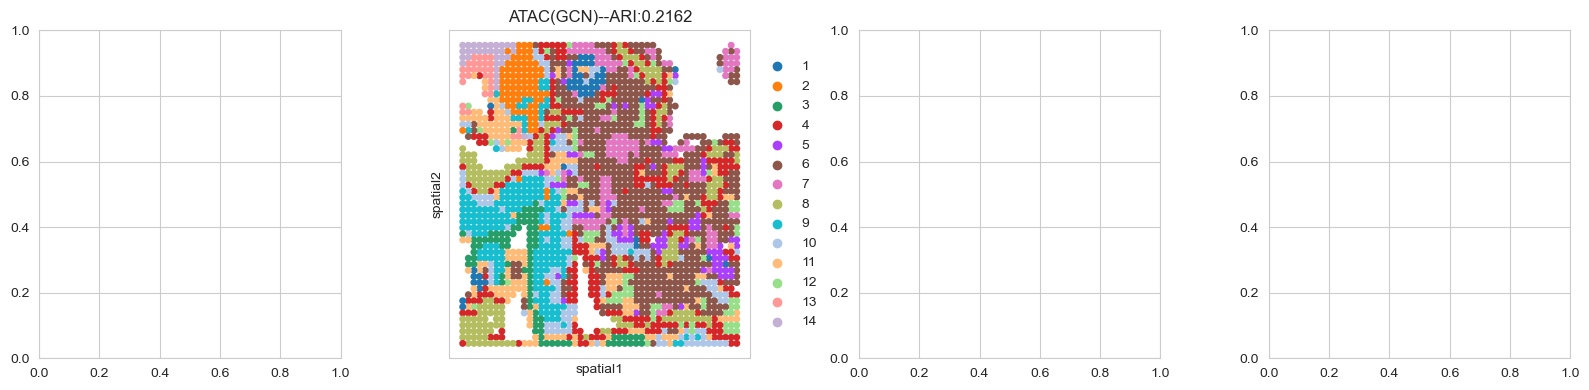

In [48]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 4, figsize=(16, 4))

# sc.pl.embedding(adata_omics2, basis='spatial',color='leiden1', ax=ax_list[0],title=f'ADT(Raw)--ARI:{ari_score_lei:.4f}',s=50, show=False)
sc.pl.embedding(adata_omics2, basis='spatial', color='AE', ax=ax_list[1], title=f'ATAC(GCN)--ARI:{ari_score_ae:.4f}',s=100, show=False)
# sc.pl.embedding(adata_omics2, basis='spatial',color='AE_ZINB', ax=ax_list[2],title=f'ADT(ZINB)--ARI:{ari_score_ZINB:.4f}',s=50, show=False)
# sc.pl.embedding(adata_omics2, basis='spatial',color='Denoise', ax=ax_list[3],title=f'ADT(denoise_emb)--ARI:{ari_score_denoise:.4f}',s=100, show=False)

plt.tight_layout(w_pad=0.5)
plt.show()

In [ ]:
import torch
import torch.nn as nn

# 假设标签数据是 Pandas Series，和图片中的类似
ground_truth = adata_omics2.obs['AE']
# ground_truth = adata_omics1.obs['ground_truth']

# 将 Pandas Series 转为 PyTorch Tensor（整数类型）
labels = torch.tensor(ground_truth.values.astype(int), dtype=torch.long)

# 获取标签的最大值（确定类别数）
num_classes = labels.max().item() + 1  # 最大类别数 + 1

# 定义嵌入层
embedding_layer = nn.Embedding(num_classes, 32)

# 通过嵌入层生成64维嵌入向量
label_embeddings = embedding_layer(labels).detach().numpy()

adata_omics2.obsm['label_embeddings_AE'] = label_embeddings
# adata_omics2.obsm['label_embeddings'] = label_embeddings

print("嵌入向量形状：", adata_omics2.obsm['label_embeddings_AE'].shape)

In [ ]:
# 提取空间坐标
slices_omics1_spatial = adata_omics1.obsm['spatial']
slices_omics2_spatial = adata_omics2.obsm['spatial']

# 提取嵌入矩阵
emb_latent_omics1 = adata_omics1.obsm['emb1']
# emb_latent_omics1 = adata_omics1.obsm['feat']
# emb_latent_omics1 = adata_omics1.obsm['emb_latent_omics1']
# emb_latent_omics1 = adata_omics1.obsm['label_embeddings_ZINB']

# emb_latent_omics2 = adata_omics1.obsm['feat']
emb_latent_omics2 = adata_omics2.obsm['emb_latent_omics2']
# emb_latent_omics2 = adata_omics1.obsm['label_embeddings']
# emb_latent_omics2 = adata_omics1.obsm['emb1']
# emb_latent_omics2 = adata_omics1.obsm['label_embeddings_ZINB']
# emb_latent_omics2 = adata_omics2.obsm['label_embeddings_AE']

# 将空间坐标转换为 DataFrame 并设置为索引
import pandas as pd

df_omics1 = pd.DataFrame(emb_latent_omics1, index=[tuple(coord) for coord in slices_omics1_spatial])
df_omics2 = pd.DataFrame(emb_latent_omics2, index=[tuple(coord) for coord in slices_omics2_spatial])

# 根据omics1的顺序重新排列omics2
df_omics2_aligned = df_omics2.reindex(df_omics1.index)

# 将DataFrame转换为numpy数组
aligned_emb_latent_omics1 = df_omics1.to_numpy()
aligned_emb_latent_omics2 = df_omics2_aligned.to_numpy()

# 输出对齐结果
print(aligned_emb_latent_omics1.shape)
print(aligned_emb_latent_omics2.shape)

In [ ]:
aligned_emb_latent_omics1.std()

In [ ]:
aligned_emb_latent_omics2.std()

In [ ]:
class ConditionalDiffusionDataset():
    def __init__(self, adata_omics1, adata_omics2):
        self.adata_omics1 = adata_omics1
        self.adata_omics2 = adata_omics2

        self.st_sample = torch.tensor(self.adata_omics1, dtype=torch.float32)
        self.con_sample = torch.tensor(self.adata_omics2, dtype=torch.float32)
        self.con_data = torch.tensor(self.adata_omics2, dtype=torch.float32)

    def __len__(self):
        return len(self.adata_omics1)

    def __getitem__(self, idx):
        return self.st_sample[idx], self.con_sample[idx], self.con_data

In [ ]:
dataset = ConditionalDiffusionDataset(aligned_emb_latent_omics2, aligned_emb_latent_omics1) # 扩散前一个，后一个是条件

random_seed = 2024
fix_seed(random_seed)

com_mtx = run_diff(
    dataset,

    k=3,
    batch_size=512,
    hidden_size=256,  #
    learning_rate=1e-3,

    num_epoch=1000,
    diffusion_step=800,

    depth=6,
    head=16,
    pca_dim=50,

    device='cuda:0',
    classes=6,
    patience=20,

    bias=1
)


In [ ]:
# adata_omics1.obsm['denoise_emb'] = com_mtx

In [ ]:
adata_omics2.obsm['denoise_emb'] = com_mtx

In [ ]:
from SpatialGlue.utils import clustering

tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_omics1, key='emb1', add_key='AE_ZINB', n_clusters=14, end=2, method=tool, use_pca=True)
# clustering(adata_omics1, key='denoise_emb', add_key='Denoise', n_clusters=10, end=1.4, method=tool, use_pca=True)

sc.pp.neighbors(adata_omics1)
sc.tl.leiden(adata_omics1, key_added='leiden1', random_state=10, resolution=0.69)

In [ ]:
sc.pp.neighbors(adata_omics1)
sc.tl.leiden(adata_omics1, key_added='leiden1', random_state=10, resolution=1.5)

In [ ]:
# adata_omics1 = run_leiden(adata_omics1, n_cluster=14, use_rep="denoise_emb", key_added="Denoise")

In [ ]:
tool = 'leiden'  # mclust, leiden, and louvain
clustering(adata_omics1, key='denoise_emb', add_key='Denoise', n_clusters=14, end=2, method=tool, use_pca=True)

In [ ]:
tool = 'leiden'  # mclust, leiden, and louvain
clustering(adata_omics2, key='denoise_emb', add_key='Denoise', n_clusters=14, end=1.6, method=tool, use_pca=True)

In [ ]:
# adata_omics2 = run_leiden(adata_omics2, n_cluster=14, use_rep="denoise_emb", key_added="Denoise")

In [ ]:
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_omics2, key='denoise_emb', add_key='Denoise', n_clusters=14, end=1.2, method=tool, use_pca=True)

In [ ]:
from sklearn.metrics import adjusted_rand_score

ground_truth = adata_omics1.obs['Joint_clusters']
# leiden1 = adata_omics1.obs['leiden1']
# ae = adata_omics1.obs['AE']
# ae_zinb = adata_omics2.obs['AE']
denoise = adata_omics2.obs['Denoise']

# ari_score_lei = adjusted_rand_score(ground_truth, leiden1)
# ari_score_ae = adjusted_rand_score(ground_truth, ae)
# ari_score_aezinb = adjusted_rand_score(ground_truth, ae_zinb)
ari_score_denoise = adjusted_rand_score(ground_truth, denoise)
ari_score_denoise

In [ ]:
## 蛋白质做条件
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 4, figsize=(18, 4))

# sc.pl.embedding(adata_omics1, basis='spatial', color='leiden1', ax=ax_list[0], s=100, show=False)
# ax_list[0].set_title(f'RNA(Raw)--ARI:{ari_score_lei:.4f}', fontsize=16)
# 
sc.pl.embedding(adata_omics2, basis='spatial',color='AE', ax=ax_list[1],s=100, show=False)
ax_list[1].set_title(f'ATAC(GCN)--ARI:{ari_score_ae:.4f}', fontsize=16)
# 
# sc.pl.embedding(adata_omics1, basis='spatial', color='AE_ZINB', ax=ax_list[1], s=100, show=False)
# ax_list[1].set_title(f'RNA(ZINB_en)--ARI:{ari_score_aezinb:.4f}', fontsize=16)

sc.pl.embedding(adata_omics2, basis='spatial', color='Denoise', ax=ax_list[2], s=100, show=False)
ax_list[2].set_title(f'ATAC(denoise_emb)--ARI:{ari_score_denoise:.4f}', fontsize=16)

plt.tight_layout(w_pad=0.5)
plt.show()

In [ ]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 4, figsize=(16, 4))

# sc.pl.embedding(adata_omics2, basis='spatial',color='leiden1', ax=ax_list[0],title=f'ADT(Raw)--ARI:{ari_score_lei:.4f}',s=50, show=False)
sc.pl.embedding(adata_omics2, basis='spatial', color='AE', ax=ax_list[1], title=f'ATAC(GCN)--ARI:{ari_score_ae:.4f}',
                s=100, show=False)
# sc.pl.embedding(adata_omics2, basis='spatial',color='AE_ZINB', ax=ax_list[2],title=f'ADT(ZINB)--ARI:{ari_score_ZINB:.4f}',s=50, show=False)
# sc.pl.embedding(adata_omics2, basis='spatial',color='Denoise', ax=ax_list[3],title=f'ADT(denoise_emb)--ARI:{ari_score_denoise:.4f}',s=100, show=False)

plt.tight_layout(w_pad=0.5)
plt.show()

In [ ]:
sc.pp.neighbors(adata_omics2, use_rep='denoise_emb', n_neighbors=10)
sc.tl.umap(adata_omics2)

In [ ]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata_omics2.obs['Joint_clusters']
ae = adata_omics2.obs['Denoise']

# 计算 ARI
ari_score_ours = adjusted_rand_score(ground_truth, ae)

print(f"Adjusted Rand Index (ARI) between ground_truth and AE: {ari_score_ours:.4f}")

In [ ]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(10, 4))

sc.pl.umap(adata_omics2, color='Denoise', ax=ax_list[0], title='Ours', s=20, show=False)
sc.pl.embedding(adata_omics2, basis='spatial', color='Denoise', ax=ax_list[1], title=f'Ours--ARI:{ari_score_ours:.4f}',
                s=100, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:
sc.pl.umap(adata_omics1, color=["Combined_Clusters_annotation", "Denoise"], title=["annotation", "Ours"],wspace=0.5)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
# from metric import jaccard, Dice, F_measure

GT_list = adata_omics1.obs['Combined_Clusters']
# SG_list = read_list_from_file(args.SpatialGlue_path)
Our_list = adata_omics1.obs['leiden1']

Our_mutual_info = mutual_info_score(GT_list, Our_list)
print('Ours\n')
print(f"Mutual Information: {Our_mutual_info:.6f}")

Our_nmi = normalized_mutual_info_score(GT_list, Our_list)
print(f"(NMI): {Our_nmi:.6f}")

Our_ami = adjusted_mutual_info_score(GT_list, Our_list)
print(f"(AMI): {Our_ami:.6f}")

Our_V = v_measure_score(GT_list, Our_list)
print(f"V-measure: {Our_V:.6f}")

Our_homogeneity = homogeneity_score(GT_list, Our_list)
Our_completeness = completeness_score(GT_list, Our_list)
print(f"Homogeneity: {Our_homogeneity:.6f} ")
print(f"Completeness: {Our_completeness:.6f}")
Our_ari = adjusted_rand_score(GT_list, Our_list)
print(f"(ARI): {Our_ari:.6f}")

Our_fmi = fowlkes_mallows_score(GT_list, Our_list)
print(f"(FMI): {Our_fmi:.6f}")

In [ ]:
# adata_omics1 = sc.read_h5ad('E18_rna_afterdiffusion.h5ad')

In [ ]:
adata1 = adata_omics1.copy()
adata2 = adata_omics2.copy()

In [ ]:
data_type = '10x'
# data_type = 'Stereo-CITE-seq'
from SpatialGlue.preprocess import pca

# adata1_high =  adata1[:, adata1.var['highly_variable']]
# adata1.obsm['feat'] = pca(adata1_high, n_comps=adata_omics2.obsm['X_lsi'].shape[1])
# adata1.obsm['feat'] = pca(adata1, use_reps='emb_latent_omics1',n_comps=adata_omics2.n_vars-1)
# adata1.obsm['feat'] = pca(adata1, use_reps='emb1',n_comps=64)
# adata1.obsm['feat'] = pca(adata1, use_reps='denoise_emb',n_comps=64)
adata1.obsm['feat'] = adata1.obsm['denoise_emb']
# adata1.obsm['feat'] = adata_omics2.obsm['label_embeddings_AE']
# adata1.obsm['feat'] = pca(adata1, use_reps='recon',n_comps=adata_omics2.n_vars-1)
# adata1.obsm['feat'] = adata1.obsm['emb1']

# adata2.obsm['feat'] = pca(adata2, n_comps=adata2.n_vars-1)
# adata2.obsm['feat'] = pca(adata2, use_reps='denoise_emb',n_comps=64)
# adata2.obsm['feat'] = pca(adata2, use_reps='denoise_emb1',n_comps=adata2.n_vars-1)
adata2.obsm['feat'] = adata2.obsm['emb_latent_omics2']
# adata2.obsm['feat'] = adata2.obsm['denoise_emb']
# adata2.obsm['feat'] = adata_omics2.obsm['label_embeddings_AE']
# adata2.obsm['feat'] = pca(adata2, use_reps='emb_latent_omics2',n_comps=32)
# adata2.obsm['feat'] = adata2.obsm['X_lsi'].copy()

from SpatialGlue.preprocess import construct_neighbor_graph

data = construct_neighbor_graph(adata1, adata2, datatype=data_type)

In [ ]:
# define model
# data_type = '10x'

device = 'cuda:0'
from SpatialGlue.preprocess import fix_seed

random_seed = 2024
fix_seed(random_seed)

from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue

model = Train_SpatialGlue(data, datatype=data_type, device=device)

# train model
output = model.train()

In [ ]:
adata = adata1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['SpatialGlue'] = output['SpatialGlue'].copy()
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

In [ ]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering

tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=14, end=1.6, method=tool, use_pca=True)

In [ ]:
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=10)
sc.tl.umap(adata)

In [ ]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata.obs['Combined_Clusters']
ae = adata.obs['SpatialGlue']

# 计算 ARI
ari_score_spatialglue = adjusted_rand_score(ground_truth, ae)

print(f"Adjusted Rand Index (ARI) between ground_truth and AE: {ari_score_spatialglue:.4f}")

In [ ]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(10, 4))

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=50, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1],
                title=f'SpatialGlue--ARI:{ari_score_spatialglue:.4f}', s=100, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:

from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
# from metric import jaccard, Dice, F_measure

GT_list = adata.obs['Combined_Clusters']
Our_list = adata.obs['SpatialGlue']

Our_mutual_info = mutual_info_score(GT_list, Our_list)
print('SpatialGlue\n')
print(f"Mutual Information: {Our_mutual_info:.6f}")

Our_nmi = normalized_mutual_info_score(GT_list, Our_list)
print(f"(NMI): {Our_nmi:.6f}")

Our_ami = adjusted_mutual_info_score(GT_list, Our_list)
print(f"(AMI): {Our_ami:.6f}")

Our_V = v_measure_score(GT_list, Our_list)
print(f"V-measure: {Our_V:.6f}")

Our_homogeneity = homogeneity_score(GT_list, Our_list)
Our_completeness = completeness_score(GT_list, Our_list)
print(f"Homogeneity: {Our_homogeneity:.6f} ")
print(f"Completeness: {Our_completeness:.6f}")
Our_ari = adjusted_rand_score(GT_list, Our_list)
print(f"(ARI): {Our_ari:.6f}")

Our_fmi = fowlkes_mallows_score(GT_list, Our_list)
print(f"(FMI): {Our_fmi:.6f}")

In [ ]:
from run_diff_ours_code.integration import *

In [ ]:
# adata_omics1 = sc.read_h5ad('E18_rna_afterdiffusion.h5ad')

## integration

In [ ]:
# adata_omics1.write('mouse_embryo_RNA_processed.h5ad')
# adata_omics2.write('mouse_embryo_ATAC_afterdiff.h5ad')

In [ ]:
# adata_omics1 = sc.read_h5ad('mouse_embryo_RNA_processed.h5ad')
# adata_omics2 = sc.read_h5ad('mouse_embryo_ATAC_afterdiff.h5ad')

In [ ]:
adata1 = adata_omics1.copy()
adata2 = adata_omics2.copy()

In [ ]:
data_type = '10x'
# data_type = 'Stereo-CITE-seq'

adata1.obsm['feat'] = adata1.obsm['emb1']

adata2.obsm['feat'] = adata2.obsm['denoise_emb']

from SpatialGlue.preprocess import construct_neighbor_graph,adjacent_matrix_preprocessing

data = construct_neighbor_graph(adata1, adata2, datatype=data_type)

In [ ]:
device = 'cuda:0'

adj = adjacent_matrix_preprocessing(adata1, adata2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)
adj_feature_omics1 = adj['adj_feature_omics1'].to(device)
adj_feature_omics2 = adj['adj_feature_omics2'].to(device)

In [ ]:
def run_leiden(adata, n_cluster, use_rep="embeddings", key_added="Nleiden", range_min=0, range_max=3, max_steps=30, tolerance=0):
    sc.pp.neighbors(adata, use_rep=use_rep)
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(adata, resolution=this_resolution)
        this_clusters = adata.obs['leiden'].nunique()

        if this_clusters > n_cluster+tolerance:
            this_max = this_resolution
        elif this_clusters < n_cluster-tolerance:
            this_min = this_resolution
        else:
            print("Succeed to find %d clusters at resolution %.3f"%(n_cluster, this_resolution))
            adata.obs[key_added] = adata.obs["leiden"]
            
            return adata
        
        this_step += 1
    
    print('Cannot find the number of clusters')
    adata.obs[key_added] = adata.obs["leiden"]
    return adata

In [ ]:
import torch
import torch.optim as optim
from run_diff_ours_code.integration import *

features_omics1 = torch.FloatTensor(adata1.obsm['feat'].copy()).to(device)
features_omics2 = torch.FloatTensor(adata2.obsm['feat'].copy()).to(device)

from SpatialGlue.preprocess import fix_seed

random_seed = 2024 # 2024
fix_seed(random_seed)

result = train_and_infer(
    features_omics1=features_omics1,
    features_omics2=features_omics2,
    adj_spatial_omics1=adj_spatial_omics1,
    adj_feature_omics1=adj_feature_omics1,
    adj_spatial_omics2=adj_spatial_omics2,
    adj_feature_omics2=adj_feature_omics2,
    device=device,
    epochs=200 # 200
)

In [ ]:
adata = adata1.copy()
adata.obsm['Ours'] = result['emb_latent_combined'].detach().cpu().numpy().copy()
adata.obsm['alpha'] = result['alpha_omics_1_2'].detach().cpu().numpy().copy()
adata.obsm['emb_latent_feat_combined'] = result['emb_latent_feat_combined'].detach().cpu().numpy().copy()
adata.obsm['emb_latent_spatial_combined'] = result['emb_latent_spatial_combined'].detach().cpu().numpy().copy()

In [ ]:
adata = run_leiden(adata, n_cluster=14, use_rep="Ours", key_added="Ours")

In [ ]:
# # we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering

tool = 'leiden'  # mclust, leiden, and louvain
clustering(adata, key='Ours', add_key='Ours', n_clusters=14, end=0.9, method=tool, use_pca=True)

In [ ]:
adata = sc.read_h5ad('mouse_embryo_inte.h5ad')

In [ ]:
sc.pp.neighbors(adata, use_rep='Ours', n_neighbors=10)
sc.tl.umap(adata)

In [ ]:
np.sum(adata.X == adata.layers['counts'])

In [ ]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata.obs['Joint_clusters']
ae = adata.obs['Ours']

# 计算 ARI
ari_score_ours = adjusted_rand_score(ground_truth, ae)

print(f"Adjusted Rand Index (ARI) between ground_truth and AE: {ari_score_ours:.4f}")

In [ ]:
sc.pl.umap(adata, color=["Joint_clusters", "Ours"], title=["annotation", "Ours"],wspace=0.5)

In [ ]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(10, 4))

# sc.pl.umap(adata, color='Ours', ax=ax_list[0], title='Ours', s=50, show=False)
sc.pl.embedding(adata, basis='spatial', color='Ours', ax=ax_list[1],
                title=f'Ours--ARI:{ari_score_ours:.4f}', s=100, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:
# # we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
# 
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata, key='emb_latent_spatial_combined', add_key='emb_latent_spatial_combined', n_clusters=14, end=1.6, method=tool, use_pca=True)

In [ ]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata.obs['Combined_Clusters']
ae = adata.obs['emb_latent_spatial_combined']

# 计算 ARI
ari_score_spatial = adjusted_rand_score(ground_truth, ae)

print(f"Adjusted Rand Index (ARI) between ground_truth and AE: {ari_score_spatial:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# 创建新的图像，并设置大小
fig, ax = plt.subplots(figsize=(6,6))  # 可以根据需要调整尺寸

# 绘制 UMAP 图像，color 参数指示使用 SpatialGlue 这一列的颜色信息
sc.pl.umap(adata, color=["Ours"], ax=ax, show=False, legend_loc=None)

# 设置标题
ax.set_title(f'Ours', fontsize=20)

# 调整图像边距，避免裁剪
plt.subplots_adjust(right=0.9)

# 保存图像到指定路径，确保高质量保存
save_path = "E:/yan0/ours/result/figs/integration/mouse_embryo/Ours_umap.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

# 显示图像
plt.show()


In [ ]:
# visualization
import matplotlib.pyplot as plt

# 创建新的图像，并设置大小
fig, ax = plt.subplots(figsize=(3,3))  # 设置图像宽度为 10 英寸，高度为 8 英寸

# 绘制图像，将图绘制到自定义的 `ax` 上
sc.pl.embedding(
    adata, 
    basis='spatial', 
    color='Ours', 
    title=f'Ours--ARI:{ari_score_ours:.4f}', 
    s=90, 
    show=False, 
    ax=ax,  # 将绘制放入指定的 `ax`
    legend_loc=None  # 禁用图例

)

# 设置标题字体大小
ax.set_title(f'Ours--ARI:{ari_score_ours:.4f}', fontsize=20)

# 去除坐标轴
ax.axis('off')

# 调整布局，减少多余空白
plt.tight_layout(pad=0)

# 保存图像到指定路径
save_path = "E:/yan0/ours/result/figs/integration/mouse_embryo/Ours.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

# 显示图像
plt.show()

In [ ]:
sc.pp.neighbors(adata, use_rep='emb_latent_spatial_combined', n_neighbors=10)
sc.tl.umap(adata)

In [ ]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(10, 4))

sc.pl.umap(adata, color='emb_latent_spatial_combined', ax=ax_list[0], title='Ours(Spatial)', s=50, show=False)
sc.pl.embedding(adata, basis='spatial', color='emb_latent_spatial_combined', ax=ax_list[1],
                title=f'Ours(Spatial)--ARI:{ari_score_spatial:.4f}', s=100, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:
# # we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
# 
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata, key='emb_latent_feat_combined', add_key='emb_latent_feat_combined', n_clusters=14, end=1.6, method=tool, use_pca=True)

In [ ]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata.obs['Combined_Clusters']
ae = adata.obs['emb_latent_feat_combined']

# 计算 ARI
ari_score_feat = adjusted_rand_score(ground_truth, ae)

print(f"Adjusted Rand Index (ARI) between ground_truth and AE: {ari_score_feat:.4f}")

In [ ]:
sc.pp.neighbors(adata, use_rep='emb_latent_feat_combined', n_neighbors=10)
sc.tl.umap(adata)

In [ ]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(10, 4))

sc.pl.umap(adata, color='emb_latent_feat_combined', ax=ax_list[0], title='Ours(Feat)', s=50, show=False)
sc.pl.embedding(adata, basis='spatial', color='emb_latent_feat_combined', ax=ax_list[1],
                title=f'Ours(Feat)--ARI:{ari_score_feat:.4f}', s=100, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
# from metric import jaccard, Dice, F_measure

GT_list = adata.obs['Combined_Clusters']
Our_list = adata.obs['SpatialGlue']

Our_mutual_info = mutual_info_score(GT_list, Our_list)
print('Ours\n')
print(f"Mutual Information: {Our_mutual_info:.6f}")

Our_nmi = normalized_mutual_info_score(GT_list, Our_list)
print(f"(NMI): {Our_nmi:.6f}")

Our_ami = adjusted_mutual_info_score(GT_list, Our_list)
print(f"(AMI): {Our_ami:.6f}")

Our_V = v_measure_score(GT_list, Our_list)
print(f"V-measure: {Our_V:.6f}")

Our_homogeneity = homogeneity_score(GT_list, Our_list)
Our_completeness = completeness_score(GT_list, Our_list)
print(f"Homogeneity: {Our_homogeneity:.6f} ")
print(f"Completeness: {Our_completeness:.6f}")
Our_ari = adjusted_rand_score(GT_list, Our_list)
print(f"(ARI): {Our_ari:.6f}")

Our_fmi = fowlkes_mallows_score(GT_list, Our_list)
print(f"(FMI): {Our_fmi:.6f}")

In [ ]:
import argparse
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from esda.moran import Moran
from libpysal.weights import DistanceBand
from libpysal.weights import KNN
coords = np.array(adata.obsm['spatial'])[:, :2]  # Use only the first two columns
labels = adata.obs['Ours'].astype(float)  # Ensure labels are numerical
w_knn = KNN(coords, k=3)
# 计算 Moran's I
moran = Moran(labels, w_knn)
# 打印 Moran's I 结果
print(moran.I)  # 打印 Moran's I 值

# 将结果保存到 DataFrame
results = {
    'Method': ['Ours'],
    'Moran I': [moran.I],
}

df_results = pd.DataFrame(results)

# 将结果保存到 CSV 文件
# csv_file = 'E:/yan0/ours/result/integration/human_skin_inte_moran.csv'  # 设置 CSV 文件名
# df_results.to_csv(csv_file, mode='a', header=not pd.io.common.file_exists(csv_file), index=False)

# print(f"Results saved to {csv_file}")

In [ ]:
# adata.write('mouse_embryo_inte.h5ad')

In [ ]:
adata = sc.read_h5ad('mouse_embryo_inte.h5ad')

## w/o denoise

In [ ]:
adata1 = adata_omics1.copy()
adata2 = adata_omics2.copy()

In [ ]:
data_type = '10x'
# data_type = 'Stereo-CITE-seq'

# adata1.obsm['feat'] = pca(adata1, use_reps='denoise_emb',n_comps=64) # 就这个别动，0.55
adata1.obsm['feat'] = adata1.obsm['emb1']

adata2.obsm['feat'] = adata2.obsm['emb_latent_omics2']

# adata2.obsm['feat'] = pca(adata2, use_reps='emb_latent_omics2',n_comps=64) # 就这个别动，0.55

from SpatialGlue.preprocess import construct_neighbor_graph,adjacent_matrix_preprocessing

data = construct_neighbor_graph(adata1, adata2, datatype=data_type)

In [ ]:
device = 'cuda:0'

adj = adjacent_matrix_preprocessing(adata1, adata2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)
adj_feature_omics1 = adj['adj_feature_omics1'].to(device)
adj_feature_omics2 = adj['adj_feature_omics2'].to(device)

In [ ]:
def run_leiden(adata, n_cluster, use_rep="embeddings", key_added="Nleiden", range_min=0, range_max=3, max_steps=30, tolerance=0):
    sc.pp.neighbors(adata, use_rep=use_rep)
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(adata, resolution=this_resolution)
        this_clusters = adata.obs['leiden'].nunique()

        if this_clusters > n_cluster+tolerance:
            this_max = this_resolution
        elif this_clusters < n_cluster-tolerance:
            this_min = this_resolution
        else:
            print("Succeed to find %d clusters at resolution %.3f"%(n_cluster, this_resolution))
            adata.obs[key_added] = adata.obs["leiden"]
            
            return adata
        
        this_step += 1
    
    print('Cannot find the number of clusters')
    adata.obs[key_added] = adata.obs["leiden"]
    return adata

In [ ]:
import torch
import torch.optim as optim
from run_diff_ours_code.integration import *

features_omics1 = torch.FloatTensor(adata1.obsm['feat'].copy()).to(device)
features_omics2 = torch.FloatTensor(adata2.obsm['feat'].copy()).to(device)

from SpatialGlue.preprocess import fix_seed

random_seed = 2024 # 2024
fix_seed(random_seed)

result = train_and_infer(
    features_omics1=features_omics1,
    features_omics2=features_omics2,
    adj_spatial_omics1=adj_spatial_omics1,
    adj_feature_omics1=adj_feature_omics1,
    adj_spatial_omics2=adj_spatial_omics2,
    adj_feature_omics2=adj_feature_omics2,
    device=device,
    epochs=200 # 300
)

In [ ]:
adata = adata1.copy()
adata.obsm['Ours_w/o_diff'] = result['emb_latent_combined'].detach().cpu().numpy().copy()
adata.obsm['alpha'] = result['alpha_omics_1_2'].detach().cpu().numpy().copy()
adata.obsm['emb_latent_feat_combined'] = result['emb_latent_feat_combined'].detach().cpu().numpy().copy()
adata.obsm['emb_latent_spatial_combined'] = result['emb_latent_spatial_combined'].detach().cpu().numpy().copy()

In [ ]:
adata = run_leiden(adata, n_cluster=14, use_rep="Ours_w/o_diff", key_added="Ours_w/o_diff")

In [ ]:
sc.pp.neighbors(adata, use_rep='Ours_w/o_diff', n_neighbors=10)
sc.tl.umap(adata)

In [ ]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata.obs['Joint_clusters']
ae = adata.obs['Ours_w/o_diff']

# 计算 ARI
ari_score_ours = adjusted_rand_score(ground_truth, ae)

print(f"Adjusted Rand Index (ARI) between ground_truth and AE: {ari_score_ours:.4f}")

In [ ]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(10, 4))

sc.pl.umap(adata, color='Ours_w/o_diff', ax=ax_list[0], title='Ours', s=50, show=False)
sc.pl.embedding(adata, basis='spatial', color='Ours_w/o_diff', ax=ax_list[1],
                title=f'Ours--ARI:{ari_score_ours:.4f}', s=100, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# 创建新的图像，并设置大小
fig, ax = plt.subplots(figsize=(6,6))  # 可以根据需要调整尺寸

# 绘制 UMAP 图像，color 参数指示使用 SpatialGlue 这一列的颜色信息
sc.pl.umap(adata, color=["Ours_w/o_diff"], ax=ax, show=False, legend_loc=None)

# 设置标题
ax.set_title(f'Ours(w/o denoise)', fontsize=20)

# 调整图像边距，避免裁剪
plt.subplots_adjust(right=0.9)

# 保存图像到指定路径，确保高质量保存
save_path = "E:/yan0/ours/result/figs/integration/mouse_embryo/Ours_wo_denoise_umap.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

# 显示图像
plt.show()


In [ ]:
# visualization
import matplotlib.pyplot as plt

# 创建新的图像，并设置大小
fig, ax = plt.subplots(figsize=(3,3))  # 设置图像宽度为 10 英寸，高度为 8 英寸

# 绘制图像，将图绘制到自定义的 `ax` 上
sc.pl.embedding(
    adata, 
    basis='spatial', 
    color='Ours_w/o_diff', 
    title=f'Ours(w/o denoise)--ARI:{ari_score_ours:.4f}', 
    s=90, 
    show=False, 
    ax=ax,  # 将绘制放入指定的 `ax`
    legend_loc=None  # 禁用图例

)

# 设置标题字体大小
ax.set_title(f'Ours(w/o denoise)--ARI:{ari_score_ours:.4f}', fontsize=20)

# 去除坐标轴
ax.axis('off')

# 调整布局，减少多余空白
plt.tight_layout(pad=0)

# 保存图像到指定路径
save_path = "E:/yan0/ours/result/figs/integration/mouse_embryo/Ours_wo_denoise.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

# 显示图像
plt.show()

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
# from metric import jaccard, Dice, F_measure

GT_list = adata.obs['Combined_Clusters']
Our_list = adata.obs['SpatialGlue']

Our_mutual_info = mutual_info_score(GT_list, Our_list)
print('Ours\n')
print(f"Mutual Information: {Our_mutual_info:.6f}")

Our_nmi = normalized_mutual_info_score(GT_list, Our_list)
print(f"(NMI): {Our_nmi:.6f}")

Our_ami = adjusted_mutual_info_score(GT_list, Our_list)
print(f"(AMI): {Our_ami:.6f}")

Our_V = v_measure_score(GT_list, Our_list)
print(f"V-measure: {Our_V:.6f}")

Our_homogeneity = homogeneity_score(GT_list, Our_list)
Our_completeness = completeness_score(GT_list, Our_list)
print(f"Homogeneity: {Our_homogeneity:.6f} ")
print(f"Completeness: {Our_completeness:.6f}")
Our_ari = adjusted_rand_score(GT_list, Our_list)
print(f"(ARI): {Our_ari:.6f}")

Our_fmi = fowlkes_mallows_score(GT_list, Our_list)
print(f"(FMI): {Our_fmi:.6f}")

In [ ]:
import argparse
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from esda.moran import Moran
from libpysal.weights import DistanceBand
from libpysal.weights import KNN
coords = np.array(adata.obsm['spatial'])[:, :2]  # Use only the first two columns
labels = adata.obs['Ours'].astype(float)  # Ensure labels are numerical
w_knn = KNN(coords, k=3)
# 计算 Moran's I
moran = Moran(labels, w_knn)
# 打印 Moran's I 结果
print(moran.I)  # 打印 Moran's I 值

# 将结果保存到 DataFrame
results = {
    'Method': ['Ours'],
    'Moran I': [moran.I],
}

df_results = pd.DataFrame(results)

# 将结果保存到 CSV 文件
# csv_file = 'E:/yan0/ours/result/integration/human_skin_inte_moran.csv'  # 设置 CSV 文件名
# df_results.to_csv(csv_file, mode='a', header=not pd.io.common.file_exists(csv_file), index=False)

# print(f"Results saved to {csv_file}")

## downstream

In [ ]:
sc.tl.rank_genes_groups(adata, 'Ours', method='wilcoxon')
sc.pl.rank_genes_groups(adata,n_genes=10)

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata,n_genes=2)

In [ ]:
sc.pl.rank_genes_groups_stacked_violin(adata,n_genes=2)

In [ ]:
adata.var

In [ ]:
sc.pl.heatmap(adata,var_group_rotation=True,var_names=['Ours'],groupby='Ours')

In [ ]:
adata.obs['dpt_pseudotime']

In [ ]:
import numpy as np
def psm(xx):
    import matplotlib.pyplot as plt
    # pseudoSpatiotemporal Map (pSM) of the tissue.
    # Calculating pseudo-times 
    adata.uns['iroot'] = np.flatnonzero(adata.obs["Ours"] == '6')[xx]
    sc.tl.diffmap(adata)
    sc.tl.dpt(adata)
    pSM_values_ours = adata.obs['dpt_pseudotime'].to_numpy()
    
    # Plotting figures
    fig, axes = plt.subplots(1, 1, figsize=(6,5))  # Increased figure size to fit the colorbar
    sz = 10
    x = np.array(adata.obsm['spatial'][:,0])
    y = np.array(adata.obsm['spatial'][:,1])
    ax_temp = axes
    im = ax_temp.scatter(x, y, s=50, c=pSM_values_ours, marker='.',cmap=f"Accent")
    ax_temp.axis('off')
    ax_temp.set_title('Ours',fontsize=20)
    # ax_temp.set_title('dpt_pseudotime of PRESENT')
    
    # Flip the y-axis by 180°
    # ax_temp.invert_yaxis()
    
    # Add colorbar as a legend
    cbar = fig.colorbar(im, ax=ax_temp)
    cbar.set_label('pSM values', rotation=270, labelpad=20)  # Label for the colorbar
    
    # save_path = "E:/yan0/ours/result/figs/integration/human_skin/dpt_pseudotime.png"
    # plt.savefig(save_path, dpi=800, bbox_inches='tight', pad_inches=0.1, transparent=True)
    
    plt.tight_layout()

In [ ]:
psm(2)

In [ ]:
for i in range(60,70):
    psm(i)#88,55,66

In [ ]:
#ValueError: 'Acent' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [ ]:
sc.tl.paga(adata, groups='Ours')
sc.pl.paga(adata, color='Ours')

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# Assuming 'adata' is already loaded and contains the necessary data
# pseudoSpatiotemporal Map (pSM) of the tissue
sc.tl.draw_graph(adata, init_pos='paga')

# Draw the graph with 'LeidenClusters' and 'dpt_pseudotime' as coloring factors
sc.pl.draw_graph(adata, color=['Ours'],show=False)

# Adjust the titles after the plot has been drawn
plt.title("Ours clusters", fontsize=18, fontweight='bold')

# Adjust layout and save the plot
# save_path = "E:/yan0/ours/result/figs/integration/human_skin/Ours_clusters_paga.png"
# plt.tight_layout()
# plt.savefig(save_path, dpi=800, bbox_inches='tight', pad_inches=0.1, transparent=True)

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# Assuming 'adata' is already loaded and contains the necessary data
# pseudoSpatiotemporal Map (pSM) of the tissue
sc.tl.draw_graph(adata, init_pos='paga')

# Draw the graph with 'LeidenClusters' and 'dpt_pseudotime' as coloring factors
sc.pl.draw_graph(adata, color=['dpt_pseudotime'],show=False)

# Adjust the titles after the plot has been drawn
plt.title("Ours pSM values", fontsize=18, fontweight='bold')

# Adjust layout and save the plot
# save_path = "E:/yan0/ours/result/figs/integration/human_skin/Ours_pSM_paga.png"
# plt.tight_layout()
# plt.savefig(save_path, dpi=800, bbox_inches='tight', pad_inches=0.1, transparent=True)

# Display the plot
plt.show()

In [ ]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50, use_rep='X_pca', method='gauss')
sc.tl.diffmap(adata)

Tn_mask = np.isin(adata.obs['Ours'], ['4'])
min_stem_id = np.argmin(adata.obsm['X_diffmap'][Tn_mask, 1])
root_id = np.arange(len(Tn_mask))[Tn_mask][min_stem_id]
adata.uns['iroot'] = root_id
sc.tl.dpt(adata,n_branchings=1)

# 重要一步：不然Diffmap的图就不是典型的弧线
adata.obsm['X_diffmap_'] = adata.obsm['X_diffmap'][:,1:]

sc.pl.embedding(adata,'diffmap_',color=['dpt_pseudotime','Ours'])

In [ ]:
import squidpy as sq

print(f"squidpy=={sq.__version__}")

In [ ]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="Ours")
sq.pl.nhood_enrichment(adata, cluster_key="Ours", method="single", cmap="inferno", vmin=-50, vmax=100)

In [ ]:
sq.gr.interaction_matrix(adata, cluster_key="Ours")
sq.pl.interaction_matrix(adata, cluster_key="Ours")

In [ ]:
sq.gr.centrality_scores(
    adata,
    cluster_key="Ours",
)
sq.pl.centrality_scores(adata, cluster_key="Ours", figsize=(20, 5), s=500)

In [ ]:
sq.gr.spatial_autocorr(adata, mode="moran")
adata.uns["moranI"].head(10)

In [ ]:
sq.pl.spatial_scatter(adata,shape=None,
    color=["Mapt", "Dlx6os1", "Rtn1", "Ttr", "Ttn",'Dpysl3','Snhg11','Meg3'], size=50,)

In [ ]:
sc.tl.rank_genes_groups(adata, 'Ours')
sc.pl.rank_genes_groups_heatmap(adata)

In [ ]:
sq.gr.co_occurrence(adata, cluster_key="Ours")
sq.pl.co_occurrence(
    adata,
    cluster_key="Ours",
    clusters="4",
    figsize=(10, 5),
)

In [ ]:
sq.gr.co_occurrence(adata, cluster_key="Ours")
sq.pl.co_occurrence(
    adata,
    cluster_key="Ours",
    clusters="5",
    figsize=(10, 5),
)

### 不要选那么多genes

In [ ]:
import os
import anndata as ad
import scanpy as sc
import pandas as pd
import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

rna_s2_degs_list = []
sc.tl.rank_genes_groups(adata, groupby="Ours", method="wilcoxon",n_genes=20) # 20
rna_s2_genes = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
# rna_s2_logfoldchanges = pd.DataFrame(adata.uns["rank_genes_groups"]["logfoldchanges"])
rna_s2_pvals_adj = pd.DataFrame(adata.uns["rank_genes_groups"]["pvals_adj"])
for col in list(rna_s2_genes.columns):
    s2_genes = rna_s2_genes[col].tolist()
    # s2_logfoldchanges = rna_s2_logfoldchanges[col].tolist()
    s2_pvals_adj = rna_s2_pvals_adj[col].tolist()
    # s2_degs_list = [s2_genes[i] for i in range(len(s2_genes)) if s2_logfoldchanges[i] > 0.2 and s2_pvals_adj[i] < 0.05]
    s2_degs_list = [s2_genes[i] for i in range(len(s2_genes)) if s2_pvals_adj[i] < 0.05]

    rna_s2_degs_list.append(s2_degs_list)
    print(f"Label: {col}, Number of DEGs: {len(s2_degs_list)}")


In [ ]:
# GO analysis
save_dir = 'E:/yan0/ours/result/GO'
for i, col in enumerate(list(rna_s2_genes.columns)):
    if len(rna_s2_degs_list[i])<=10:
        print(f'{col} Skipped')
        continue
    print(col)
    enr = gp.enrichr(gene_list=rna_s2_degs_list[i], gene_sets='GO_Biological_Process_2021',organism='mouse',outdir=save_dir + f'/mouse_embryo_GO_analysis/{col}/')

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# 获取基因表达数据和伪时间数据
gene_expression = adata.X  # 假设 adata.X 是稀疏矩阵，需要转换为密集矩阵
pseudotime = adata.obs['dpt_pseudotime'].values

# 创建一个空的数据框，用来存储每个基因的相关性和P值
correlations = []
p_values = []

# 遍历每个基因
for i in range(gene_expression.shape[1]):  # 遍历每个基因
    gene_values = gene_expression[:, i]  # 获取当前基因的所有细胞表达值
    
    # 计算皮尔逊相关系数和P值
    corr, p_value = pearsonr(gene_values, pseudotime)
    
    # 存储结果
    correlations.append(corr)
    p_values.append(p_value)

# 将结果存入数据框
results_df = pd.DataFrame({
    'gene': adata.var_names,  # 基因名
    'correlation': correlations,  # 皮尔逊相关系数
    'p_value': p_values  # P值
})

# 筛选显著相关的基因
significant_genes = results_df[results_df['p_value'] < 1e-10]

# 分别提取正相关和负相关的基因
positive_genes = significant_genes[significant_genes['correlation'] > 0]
negative_genes = significant_genes[significant_genes['correlation'] < 0]

In [ ]:
positive_genes

In [ ]:
negative_genes

In [ ]:
import os
import anndata as ad
import scanpy as sc
import pandas as pd
import gseapy as gp

import warnings

top6_genes = positive_genes.nlargest(20, 'correlation')  # 选择最强的20个基因

warnings.filterwarnings("ignore")
# GO analysis
save_dir = 'E:/yan0/ours/result/GO_dpt'
enr = gp.enrichr(gene_list=top6_genes['gene'], gene_sets='GO_Biological_Process_2021',organism='mouse',outdir=save_dir + f'/mouse_embryo_positive_GO_analysis/')

In [ ]:
# GO analysis
top6_genes = negative_genes.nlargest(20, 'correlation')  # 选择最强的20个基因

save_dir = 'E:/yan0/ours/result/GO_dpt'
enr = gp.enrichr(gene_list=top6_genes['gene'], gene_sets='GO_Biological_Process_2021',organism='mouse',outdir=save_dir + f'/mouse_embryo_negative_GO_analysis/')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 选择前六个最相关的基因
top6_genes = significant_genes.nlargest(20, 'correlation')  # 选择最强的20个基因

# 1. 提取这些基因的表达数据
top6_gene_expression = adata[:, top6_genes.index].X.toarray()

# 2. 归一化基因表达数据到 [0, 1] 范围
scaler = MinMaxScaler()
normalized_gene_expression = scaler.fit_transform(top6_gene_expression)

# 3. 按伪时间对细胞进行排序
sorted_cells = np.argsort(adata.obs['dpt_pseudotime'].values)  # 获取伪时间排序的细胞索引
sorted_gene_expression = normalized_gene_expression[sorted_cells, :]  # 按伪时间排序基因表达数据

# 4. 使用 adata.var['name'] 获取基因的名称
top6_genes_name = top6_genes['gene']

# 5. 绘制热图 (交换 x 和 y 轴)
plt.figure(figsize=(6, 6))
sns.heatmap(sorted_gene_expression.T, cmap="Reds",  yticklabels=top6_genes_name, cbar_kws={'label': 'Gene Expression'})
plt.ylabel('Genes')
plt.xlabel('Cells (Sorted by Pseudotime)')
plt.title('Heatmap of Top 20 Pseudo-time Associated Genes')
plt.yticks(rotation=0)  # 旋转y轴标签，以便查看
plt.show()
